In [12]:
import time
import random
import numpy as np
import torch as th

import jax
import jax.numpy as jnp

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from utils.plots import multiviz_trajs
from utils.inference import run_pipeline_cvae

from models.cvae import CVAEModel, torch_log
from models.sampler.pixelcnn import PixelCNN
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs
from utils.load_data import get_varying_bound_conditions_num_agents
from optimizers.mlp_sf_multi_agent_varying_bounds_1 import InitModel
from optimizers.baseline_with_varying_bounds_2 import multi_agent_qp_node_base
from optimizers.mlp_sf_multi_agent_varying_bounds_1_jax import mlp_sf_multi_agent_jax

In [13]:
manualSeed = 999            
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
th.manual_seed(manualSeed)
np.random.seed(manualSeed)
th.use_deterministic_algorithms(False)

th.set_float32_matmul_precision('high')

Random Seed:  999


In [14]:
num         = 50
t_fin       = 5
num_agent   = 4

cv_name     = "vary_01"
sf_name     = "vary_01"

batch_size  = 10

nef         = 128   # Size of feature maps in encoder
ndf         = 128   # Size of feature maps in decoder

zdim        = 3     # Size of codebook vectors in the quantizer layer
znum        = 512   # number of codebook vectors

lheight     = 5     # latent vector height
lwidth      = 5     # Latent vector width

device      = th.device("cuda" if th.cuda.is_available() else "cpu")

maxiter     = 200
epsilon     = 1e-6

print(device)
# th.set_float32_matmul_precision('high')

cuda


In [15]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

dataset = get_varying_bound_conditions_num_agents(num_agent)
test_loader = iter(DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False))

if num_agent == 4:
    cond_mean, cond_std = 0.17345280945301056, 1.0734777450561523
elif num_agent == 8:
    cond_mean, cond_std = 0.17811532318592072, 1.0954965353012085   

In [16]:
cv_model = CVAEModel(
    P, Pdot, Pddot, num_agent, nvar, 
    cond_mean, cond_std, zdim, tdim=3, 
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=batch_size
)
cv_model.load_state_dict(th.load(f"./resources/weights/cvae/{cv_name}_agents_{num_agent}", weights_only=False))
ccv_model = th.compile(cv_model)

cv_model.eval()
cv_model.to(device=device);

In [17]:
pcd_features, hidden_dim_mlp, out_dim_mlp = 6*nvar*num_agent, 2048, (3*nvar*num_agent)+(3*nvar*num_agent)
inp_dim_mlp = pcd_features+(3*nvar*num_agent)+6

if num_agent == 4:
    min_inp, max_inp, inp_mean, inp_std = -2.4249918460845947, 2.4249961376190186, 0.05781755596399307, 0.6251423358917236
elif num_agent == 8:
    min_inp, max_inp, inp_mean, inp_std = -2.5, 2.5, 0.05937167629599571, 0.6380341053009033

model_sf = InitModel(18, 2048, pcd_features, inp_dim_mlp, hidden_dim_mlp, out_dim_mlp, min_inp, max_inp, inp_mean, inp_std, num_agent).to(device)

model_sf.load_state_dict(th.load(f"./resources/weights/filter/sf_{sf_name}_cv_{cv_name}_agents_{num_agent}.pth", weights_only=False))
cmodel_sf = th.compile(model_sf)

model_sf.eval()

multi_agent_learned = mlp_sf_multi_agent_jax(batch_size, num_agent)
multi_agent_learned.maxiter = maxiter
multi_agent_learned.epsilon = epsilon

multi_agent_base = multi_agent_qp_node_base(num_agent, batch_size)
multi_agent_base.maxiter = maxiter

In [18]:
x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii = next(test_loader)
(primal_residual, primal_residual_base, dual_residual, dual_residual_base), (
    x_traj, y_traj, z_traj,
    x_traj_base, y_traj_base, z_traj_base,
    x_traj_init, y_traj_init, z_traj_init,
), (mean_smoothness, mean_smoothness_base) = run_pipeline_cvae(
    x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii,
    zdim, P, cv_model, model_sf,
    multi_agent_learned, multi_agent_base, 
    num_agent, num, nvar, batch_size, lheight, lwidth, device, verbose=True, comp_type="base"
)

Random sampling time          : 0.0000 secs
VQ decoder time               : 0.0019 secs
Learned optimizer time        : 1.4930 secs
Base/Comp optimizer time      : 0.9007 secs


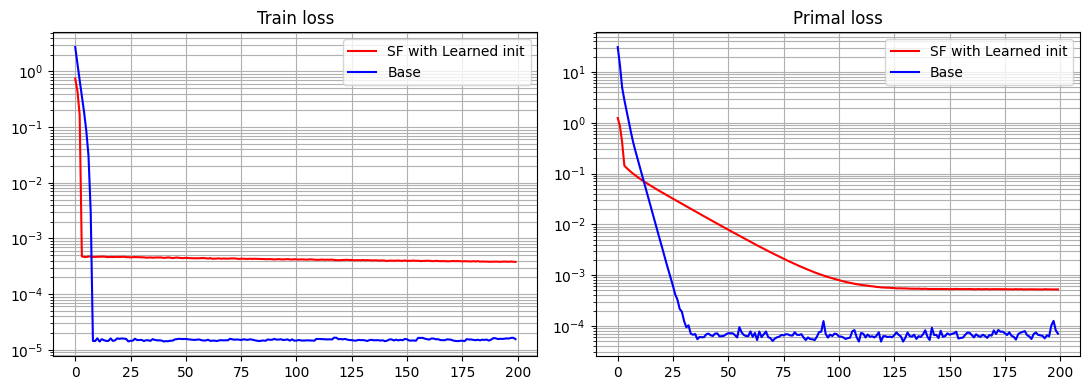

In [19]:
fig = plt.figure(figsize=(11, 4))
ax = plt.subplot(121)
ax.plot(primal_residual, '-r', label="SF with Learned init")
ax.plot(primal_residual_base, '-b', label="Base")
ax.set_title("Train loss")
ax.set_yscale('log')
ax.grid(which="both")
ax.legend(loc='upper right')

ax = plt.subplot(122)
ax.plot(dual_residual, '-r', label="SF with Learned init")
ax.plot(dual_residual_base, '-b', label="Base")
ax.set_title("Primal loss")
ax.set_yscale('log')
ax.grid(which="both")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
vx_trajs, vy_trajs, vz_trajs = np.stack([x_traj_base, x_traj_init, x_traj]), np.stack([y_traj_base, y_traj_init, y_traj]), np.stack([z_traj_base, z_traj_init, z_traj])
multiviz_trajs(vx_trajs[:3], vy_trajs[:3], vz_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600, titles=["Base", "CPred", "SF+VQ"])

In [21]:
def run_statistics(comp_type):
    primals_min, duals_min, traj_smoothness = [], [], []
    primals_min_base, duals_min_base, traj_smoothness_base = [], [], []

    stats_loader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False)

    for (x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii) in tqdm(stats_loader):
        (primal_residual, primal_residual_base, dual_residual, dual_residual_base), _, (mean_smoothness, mean_smoothness_base) = run_pipeline_cvae(
            x_init, y_init, z_init, x_fin, y_fin, z_fin, center, radii,
            zdim, P, cv_model, model_sf,
            multi_agent_learned, multi_agent_base, 
            num_agent, num, nvar, batch_size, lheight, lwidth, device, verbose=False, comp_type=comp_type
        )

        primals_min.append(primal_residual[-1]), duals_min.append(dual_residual[-1])
        primals_min_base.append(primal_residual_base[-1]), duals_min_base.append(dual_residual_base[-1])

        traj_smoothness.append(mean_smoothness)
        traj_smoothness_base.append(mean_smoothness_base)

    np.savez(
        f"./resources/results/{num_agent}/{comp_type}_batch_{batch_size}_maxiter_{multi_agent_learned.maxiter}_cv",
        primals=np.asarray(primals_min), duals=np.asarray(duals_min), 
        primals_base=np.asarray(primals_min_base), duals_base=np.asarray(duals_min_base),
        mean_smoothness=np.asarray(traj_smoothness),
        mean_smoothness_base=np.asarray(traj_smoothness_base)
    )

In [22]:
run_statistics("base")
run_statistics("sf_cpred")
run_statistics("sf_zero")

100%|██████████| 3000/3000 [04:11<00:00, 11.93it/s]
